In [1]:
import numpy as np
import torch
from scipy.integrate import odeint
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from torch import nn, autograd
import random

In [2]:
def plot_result(x, y_tensor_squuezed, x_data, y_data, yh, xp, physics_params=None):
    plt.figure(figsize=(10, 6))
    # Plot actual data
    plt.plot(x.squeeze().detach().numpy(), y_tensor_squeezed.detach().numpy(), 'r-', label='Ground Truth Data')
    # Plot model predictions
    plt.plot(x_data.squeeze().detach().numpy(), yh.squeeze().detach().numpy(), 'b--', label='Model Predictions')
    # Optionally, plot physics-based predictions if xp is provided and physics_params is not None
    if xp is not None and physics_params is not None:
        yhp = model(xp, physics_params).detach()  # Detach is used here already
        # Ensure xp is also detached before converting to numpy for plotting
        plt.plot(xp.squeeze().detach().numpy(), yhp.squeeze().numpy(), 'g:', label='Physics Predictions')
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
class AdaptedLSTM(nn.Module):
    def __init__(self, n_time_features, n_param_features, n_hidden, n_layers):
        super(AdaptedLSTM, self).__init__()
        
        # Number of input features for the LSTM is the sum of time features and parameter features
        self.lstm_input_features = n_time_features + n_param_features
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size=self.lstm_input_features, hidden_size=n_hidden, num_layers=n_layers, batch_first=True)
        
        # Output layer
        self.output_layer = nn.Linear(n_hidden, 1)
        
        # Activation function
        self.activation = nn.Tanh()

    def forward(self, x, params):
        # Assuming x is of shape [batch_size, seq_len, n_time_features]
        # And params is of shape [batch_size, n_param_features]
        
        # Repeat params across the sequence length to match x's shape
        params = params.unsqueeze(1).repeat(1, x.size(1), 1)  # Now [batch_size, seq_len, n_param_features]
        
        # Concatenate time and parameter features for each timestep
        x_combined = torch.cat((x, params), dim=2)  # Now [batch_size, seq_len, lstm_input_features]
        
        # LSTM layer
        lstm_out, (hn, cn) = self.lstm(x_combined)
        
        # Apply activation function to the output of the last timestep
        final_output = self.activation(lstm_out[:, -1, :])
        
        # Output layer without activation (assuming a regression task)
        final_output = self.output_layer(final_output)
        return final_output

In [4]:
class AdaptedRNN(nn.Module):
    def __init__(self, n_time_features, n_param_features, n_hidden, n_layers):
        super(AdaptedRNN, self).__init__()
        
        # Number of input features for the RNN is the sum of time features and parameter features
        self.rnn_input_features = n_time_features + n_param_features
        
        # RNN Layer
        self.rnn = nn.RNN(input_size=self.rnn_input_features, hidden_size=n_hidden, num_layers=n_layers, batch_first=True)
        
        # Output layer
        self.output_layer = nn.Linear(n_hidden, 1)
        
        # Activation function
        self.activation = nn.Tanh()

    def forward(self, x, params):
        # Reshape x to add a sequence length dimension of 1
        # If x is [500, 1], we reshape it to [500, 1, 1] to match [batch_size, seq_len, n_time_features]
        x = x.unsqueeze(1)  # Adds seq_len dimension
        
        # Since params is [500, 5], we also need to adjust it for concatenation
        # We want params to be [500, 1, 5] to match x's new shape for concatenation
        params = params.unsqueeze(1)  # Adds seq_len dimension
        
        # Now x_combined shape will be [500, 1, 6] after concatenation
        x_combined = torch.cat((x, params), dim=2)
        
        # Process with RNN as before
        rnn_out, _ = self.rnn(x_combined)
        final_output = rnn_out[:, -1, :]  # Taking the last timestep output
        final_output = self.activation(final_output)
        final_output = self.output_layer(final_output)
        return final_output

In [5]:
class AdaptedGRU(nn.Module):
    def __init__(self, n_time_features, n_param_features, n_hidden, n_layers):
        super(AdaptedGRU, self).__init__()
        
        # Number of input features for the GRU is the sum of time features and parameter features
        self.gru_input_features = n_time_features + n_param_features
        
        # GRU Layer
        self.gru = nn.GRU(input_size=self.gru_input_features, hidden_size=n_hidden, num_layers=n_layers, batch_first=True)
        
        # Output layer
        self.output_layer = nn.Linear(n_hidden, 1)
        
        # Activation function
        self.activation = nn.Tanh()

    def forward(self, x, params):
 
        x = x.unsqueeze(1)  # Adds seq_len dimension
   
        params = params.unsqueeze(1)  # Adds seq_len dimension
        
    
        # Concatenate time and parameter features for each timestep
        x_combined = torch.cat((x, params), dim=2)
      

        # GRU layer
        gru_out, hn = self.gru(x_combined)
        
        # Apply activation function to the output of the last timestep
        final_output = self.activation(gru_out[:, -1, :])
        
        # Output layer without activation (assuming a regression task)
        final_output = self.output_layer(final_output)
        return final_output

In [6]:
class AdaptedFCN(nn.Module):
    def __init__(self, n_time_features, n_param_features, n_hidden, n_layers):
        super(AdaptedFCN, self).__init__()
        
        # Number of input features is the sum of time features and parameter features
        self.input_features = n_time_features + n_param_features
        
        # Input layer takes combined time and parameters
        self.input_layer = nn.Linear(self.input_features, n_hidden)
        
        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(n_layers - 1):
            self.hidden_layers.append(nn.Linear(n_hidden, n_hidden))
        
        # Output layer
        self.output_layer = nn.Linear(n_hidden, 1)
        
        # Activation function
        self.activation = nn.Tanh()  # Using Tanh as an example; adjust as needed

    def forward(self, x, params):
        # Concatenate time and parameter features
        x_combined = torch.cat((x, params), dim=1)
        
        # Input layer with activation
        x = self.activation(self.input_layer(x_combined))
        
        # Hidden layers with activation
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        
        # Output layer without activation (assuming a regression task)
        x = self.output_layer(x)
        return x

In [7]:
    def duffing_generator_batch( num_batches, x):
        params_list = []  # To store parameters tensors for each batch
        y_physics_list = []  # To store the y_physics tensors for each batch

        for _ in range(num_batches):
            # Randomly generate parameters
            a = random.uniform(-2, 2)
            b = random.uniform(0, 3)
            d = random.uniform(0, 0.5)
            gamma = random.uniform(0, 3)
            w = random.uniform(0, 5)

            # Duffing differential equation solver setup
            def duffing(y, t):
                y0, y1 = y
                dydt = [y1, -d * y1 - a * y0 - b * y0**3 + gamma * np.cos(w * t)]
                return dydt

            # Initial conditions and solving the ODE
            y0 = [0, 0]
            sol = odeint(duffing, y0, x.cpu().squeeze().numpy())  # Ensure x is compatible with odeint
            y = torch.tensor(sol[:, 0], dtype=torch.float32).view(-1, 1)  # y_physics for one batch

            y_physics_list.append(y)

            # Handling parameters similarly if needed
            params = torch.tensor([d, a, b, gamma, w], dtype=torch.float32).view(1, -1).repeat(x.size(0), 1)
            params_list.append(params)
    
           # params_tensor = torch.tensor(params_list)
            #y_tensor = torch.tensor(y_physics_list)
        # Option 1: Return lists directly
        #return params_tensor, y_tensor

            # Option 2: Stack tensors to create a batch dimension explicitly
            params_tensor = torch.stack(params_list, dim=0)  # Shape: [num_batches, x.size(0), 5]
            y_physics_tensor = torch.stack(y_physics_list, dim=0)  # Shape: [num_batches, x.size(0), 1]
    
            return params_tensor, y_physics_tensor

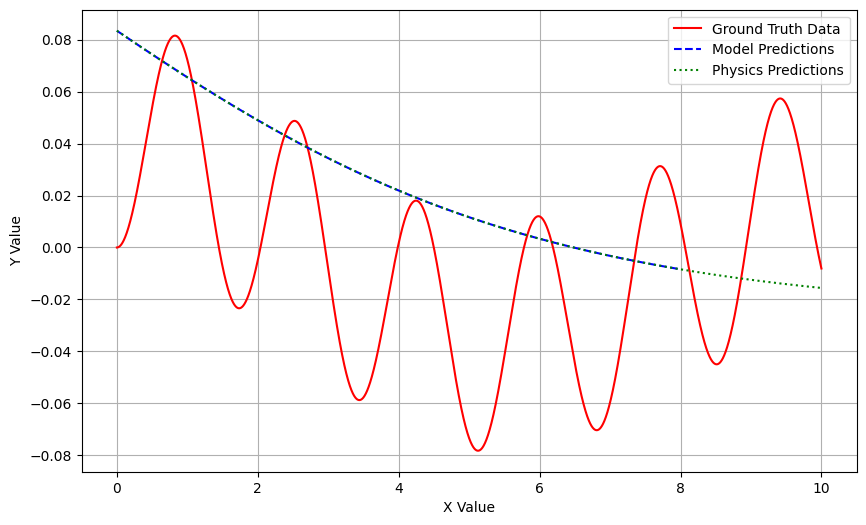

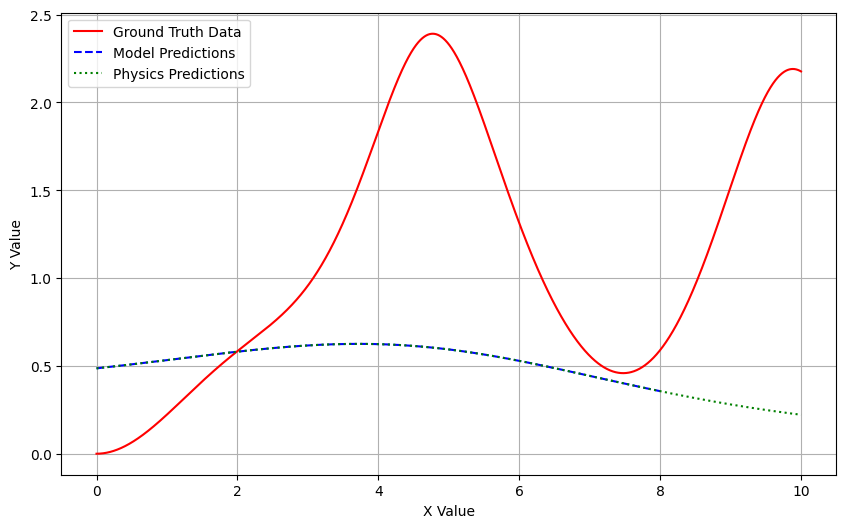

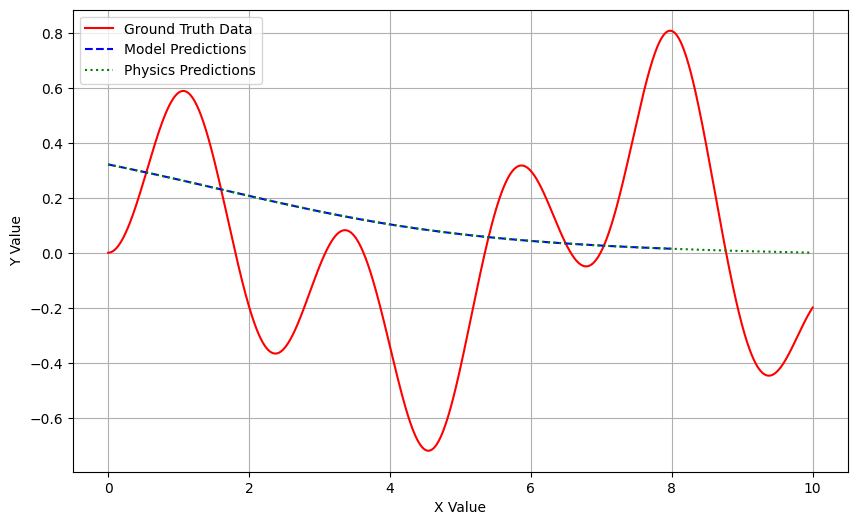

In [ ]:
# Your setup code, including model and optimizer initialization
x = torch.linspace(0, 10, 5000).view(-1,1)
x_physics = torch.linspace(0, 10, 3000).view(-1, 1).requires_grad_(True)

torch.manual_seed(123)
#model = AdaptedFCN(1, 5, 32, 8)  
#model = AdaptedRNN(1, 5, 32, 8)  
#model = AdaptedLSTM(1,5,32,8)
model = AdaptedGRU(1,5,32,8)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20048, gamma=0.5)
X_BOUNDARY = 0.0
F_BOUNDARY = 0.0

data_processed = 0  # Initialize a counter
variance_threshold = 0.000001  # Acceptable variance threshold
loss_change_threshold = 1e-8  # Acceptable change in loss
check_interval = 100  # How often to check the criteria (in epochs)
num_batches = 128
loss_history = []  # To store loss values for change calculation
variances = []  # To track variance at each checkpoint
epochs_with_checks = []  # To track epochs when checks are performed

for i in range(20000):
    epoch_losses = []  # To store losses for this epoch
    epoch_differences = []  # To store prediction differences for variance calculation
    
    for batch in range(num_batches):
        optimizer.zero_grad()
        params_tensor,y_tensor= duffing_generator_batch( num_batches, x)
        x_data = x[:int(0.8 * x.size(0))]
        y_data = y_tensor[:, :x_data.size(0), :]
        selected_params = params_tensor[0, :1, :].repeat(x_data.size(0), 1)  
        data_processed += x_data.shape[0]
        d, a, b, gamma, w = params_tensor[:, 0], params_tensor[:, 1], params_tensor[:, 2], params_tensor[:, 3], params_tensor[:, 4]
        yh = model(x_data,selected_params)
        
        # Compute the data loss by comparing the model output with the training data
        # Assuming your linear layer is named `layer`
        loss1 = torch.mean((yh - y_data)**2)
        physics_params = params_tensor[0, :1, :].repeat(x_physics.size(0), 1)   
        # Compute the physics loss by enforcing the differential equation
        yhp = model(x_physics,physics_params)
        dy_pred = autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
        d2y_pred = autograd.grad(dy_pred, x_physics, torch.ones_like(dy_pred), create_graph=True)[0]
            
        physics = d2y_pred + d * dy_pred + a * yhp + b * torch.pow(yhp, 3) - gamma * torch.cos(w * x_physics)
        loss_physics = (1e-3) * torch.mean(physics**2)
            
        # Compute the total loss as the sum of the data loss, the physics loss, and the boundary loss
        total_loss = loss1 + loss_physics 
        # Update the model parameters using backpropagation and gradient descent
        total_loss.backward()
        optimizer.step()
        y_tensor_squeezed = y_tensor.squeeze()
            # Adjust learning rate based on scheduler
        scheduler.step()
        # Collect differences for variance calculation
        differences = (yh - y_data).detach().cpu().numpy()  # Assuming y_data and yh are tensors
        epoch_differences.extend(differences.flatten())
        epoch_losses.append(total_loss.item())  # Store loss for later analysis


        # Calculate the mean loss for the epoch
    mean_loss = np.mean(epoch_losses)
    loss_history.append(mean_loss)
    
    # Check variance and loss change at specified intervals
    if (i + 1) % check_interval == 0:
        epoch_variance = np.var(epoch_differences)
        variances.append(epoch_variance)
        epochs_with_checks.append(i + 1)

        # Calculate the absolute change in loss compared to the last checkpoint
        if len(loss_history) > 1:
            loss_change = abs(loss_history[-1] - loss_history[-2])
        else:
            loss_change = float('inf')  # Initial loss change is set to inf to ensure it doesn't trigger stopping

        print(f"Epoch {i+1}, Variance: {epoch_variance}, Loss Change: {loss_change}")
        
        # Check if both the variance and loss change criteria are met
        if epoch_variance < variance_threshold and loss_change < loss_change_threshold:
            print("Both variance and loss change criteria met, consider adjusting training strategy.")
            # Save the model
            model_save_path = "/devel/thesis/rnn_pinnthesis/pinn_model.pth"
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved to {model_save_path}")
            break  # Exit training loop

    # Your original plotting code here for every few epochs
    # plot the result as training progresses
    if (i + 1) % 10 == 0:
        # Assuming x_data, selected_params are defined as part of your training loop
        yh = model(x_data, selected_params).detach()
       
        plot_result(x, y_tensor_squeezed, x_data, y_data, yh, x_physics, physics_params)
        
        # Display the plot every 6000 iterations and close it otherwise
        if (i + 1) % 6000 == 0:
            plt.show()
        else:
            plt.close("all")
# After training, plot the variance threshold chart
plt.figure(figsize=(10, 6))
plt.plot(epochs_with_checks, variances, label='Prediction Variance')
plt.axhline(y=variance_threshold, color='r', linestyle='-', label='Variance Threshold')
plt.xlabel('Epoch')
plt.ylabel('Variance')
plt.title('Model Prediction Variance Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x = torch.linspace(0, 1, 500).view(-1,1)
x_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True).to(device)
num_batches = 128
torch.manual_seed(123)
model = AdaptedFCN(1, 5, 256, 32)  # Assuming AdaptedFCN is defined elsewhere
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
model = model.to(device)
# Constants
X_BOUNDARY = torch.tensor([0.0], device=device).view(-1, 1)
F_BOUNDARY = torch.tensor([0.0], device=device).view(-1, 1)

# Training Variables
data_processed = 0
variance_threshold = 0.000001
loss_change_threshold = 1e-8
check_interval = 100
num_batches = 128
data_processed_per_epoch = []  # This will track data processed per epoch
loss_history = []
variances = []
epochs_with_checks = []

# Training Loop
for i in range(6000):
    epoch_losses = []
    epoch_differences = []
    
    for batch in range(num_batches):
        optimizer.zero_grad()
        params_tensor, y_tensor = duffing_generator_batch(num_batches, x)
        params_tensor = params_tensor.to(device)
        y_tensor = y_tensor.to(device)
        
        selected_params = params_tensor[0, :1, :].repeat(x.size(0), 1).to(device)  # Ensure selected_params is on the correct device
        y_data = y_tensor[:, 0:200:20]
        x_data = x[0:200:20].to(device)  # Ensure x_data is also on the correct device before passing to model
        
        yh = model(x_data, selected_params[0:200:20])
        # Compute the data loss
        loss1 = torch.mean((yh - y_data)**2)
        
        # Physics parameters, ensuring they're on the correct device
        physics_params = params_tensor[0, :1, :].repeat(x_physics.size(0), 1)
        physics_params = physics_params.to(device)  # Explicitly ensuring on correct device
        yhp = model(x_physics, physics_params)
        
        # Extracting individual parameters for the physics calculation
        d, a, b, gamma, w = params_tensor[:, 0], params_tensor[:, 1], params_tensor[:, 2], params_tensor[:, 3], params_tensor[:, 4]
        
        dy_pred = autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
        d2y_pred = autograd.grad(dy_pred, x_physics, torch.ones_like(dy_pred), create_graph=True)[0]
        
        physics = d2y_pred + d * dy_pred + a * yhp + b * torch.pow(yhp, 3) - gamma * torch.cos(w * x_physics)
        loss_physics = (1e-4) * torch.mean(physics**2)
        
        boundary_params = params_tensor[0, :1, :].repeat(1, 1)
        yh_boundary = model(X_BOUNDARY, boundary_params)
        loss_boundary = torch.mean((yh_boundary - F_BOUNDARY)**2)
        
        total_loss = loss1 + loss_physics + loss_boundary
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        batch_size = x_data.shape[0]  # Assuming x_data is your input batch tensor
        epoch_data_processed += batch_size
        data_processed += batch_size
        differences = (yh - y_data).detach().cpu().numpy()
        epoch_differences.extend(differences.flatten())
        epoch_losses.append(total_loss.item())

    mean_loss = np.mean(epoch_losses)
    loss_history.append(mean_loss)
    
    if (i + 1) % check_interval == 0:
        epoch_variance = np.var(epoch_differences)
        variances.append(epoch_variance)
        epochs_with_checks.append(i + 1)
        loss_change = abs(loss_history[-1] - loss_history[-2]) if len(loss_history) > 1 else float('inf')
        print(f"Epoch {i+1}, Variance: {epoch_variance}, Loss Change: {loss_change}")
        rint(f"Epoch {i+1}: Cumulative Data Processed = {data_processed}, Data Processed This Epoch = {epoch_data_processed}"
        if epoch_variance < variance_threshold and loss_change < loss_change_threshold:
            print("Criteria met, stopping training.")
            model_save_path = "/devel/thesis/rnn_pinnthesismodel.pth"
            torch.save(model.state_dict(), model_save_path)
            break

    if (i+1) % 10 == 0:
        print("Loss at Step", i+1, ":", total_loss.item())
        print(f"Epoch {i+1}, Total Data Processed: {data_processed}")
    
        # Convert tensors to CPU for plotting if they are on a GPU
        x_data_cpu = x_data.detach().cpu().numpy().squeeze()  # Squeeze to ensure correct dimensions
        y_data_cpu = y_data.detach().cpu().numpy().squeeze()  # Squeeze to ensure correct dimensions
        yh_cpu = yh.detach().cpu().numpy().squeeze()  # Also squeeze yh for consistency
    
        plt.figure(figsize=(10, 5))
        # Ensure dimension compatibility in the plot by using squeezed arrays
        plt.scatter(x_data_cpu, y_data_cpu,  color='red', label='Training points')
        plt.plot(x.numpy(), y_tensor_squeezed.detach().cpu().numpy(), label='Ground Truth')
        plt.plot(x_data_cpu, yh_cpu, label='Model Output')
        plt.title("Model Output vs. Training Data")
        plt.legend()
        plt.show()

# After the training loop
# Plot the variance threshold chart
plt.figure(figsize=(10, 6))
plt.plot(epochs_with_checks, variances, 'o-', label='Prediction Variance')
plt.axhline(y=variance_threshold, color='r', linestyle='--', label='Variance Threshold')
plt.xlabel('Epoch')
plt.ylabel('Variance')
plt.title('Model Prediction Variance Over Time')
plt.legend()
plt.grid(True)
plt.show()
